<a href="https://colab.research.google.com/github/SullyC25/Week4/blob/main/Machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive; drive.mount('/content/drive', force_remount=True)
%pip -q install numpy pandas scikit-learn matplotlib pyarrow

Mounted at /content/drive


In [3]:
import os, json, datetime
import numpy as np, pandas as pd, matplotlib.pyplot as plt

In [4]:
# Paths & choices
BASE = "/content/drive/MyDrive"
COLL = f"{BASE}/CollocationV3"
OUT  = f"{BASE}/ML"
FIG  = f"{OUT}/Figures"
os.makedirs(OUT, exist_ok=True); os.makedirs(FIG, exist_ok=True)

TAG       = "baseline"              # or "relaxed"
PAIR_KIND = "qc"                    # "min" or "qc"
PAIR_FILE = f"{COLL}/s3_j3_pairs_{TAG}_{PAIR_KIND}.parquet"

# domain + small grid for demo map
BBOX = (88.0, 93.0, 20.0, 26.0)
GRID_RES = 0.25                     # light-weight grid
TARGET_MONTH_MODE = "latest"        # "latest" or "most_samples"

print("Using pairs:", PAIR_FILE)
assert os.path.exists(PAIR_FILE), "Missing pairs parquet from CollocationV3."


Using pairs: /content/drive/MyDrive/CollocationV3/s3_j3_pairs_baseline_qc.parquet


In [5]:
# Load & prepare pairs
df = pd.read_parquet(PAIR_FILE).copy()
need = {"time_s3","lon","lat","sla_s3","sla_j3"}
missing = need - set(df.columns)
assert not missing, f"Pairs missing {missing}"

df["time_s3"] = pd.to_datetime(df["time_s3"], errors="coerce")
df = df.dropna(subset=["time_s3","lon","lat","sla_s3","sla_j3"]).reset_index(drop=True)

# robust daily-median bias → S3_bc
med = (df.assign(date=df["time_s3"].dt.floor("D"))
         .groupby("date")
         .apply(lambda g: np.nanmedian((g["sla_s3"] - g["sla_j3"]).to_numpy(dtype="float64")))
         .rename("daily_median_delta")
         .reset_index())
df = df.merge(med, left_on=df["time_s3"].dt.floor("D"), right_on="date", how="left")
df["sla_bc"] = df["sla_s3"] - df["daily_median_delta"].astype("float64")

# target to learn (pair-level residual): Δ = S3_bc − J3
df["delta"] = (df["sla_bc"] - df["sla_j3"]).astype("float64")

# light geographic trim (box only)
lon_min, lon_max, lat_min, lat_max = BBOX
df = df[(df["lon"].between(lon_min,lon_max)) & (df["lat"].between(lat_min,lat_max))].copy()


/tmp/ipython-input-3113769993.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.nanmedian((g["sla_s3"] - g["sla_j3"]).to_numpy(dtype="float64")))


In [6]:
# Features (compact)
# project lon/lat to local km around domain center
lon0 = float(np.nanmean(df["lon"])); lat0 = float(np.nanmean(df["lat"]))
def to_xy_km(lon, lat, lon0=lon0, lat0=lat0):
    x = (np.asarray(lon) - lon0) * 111.320 * np.cos(np.deg2rad(lat0))
    y = (np.asarray(lat) - lat0) * 110.574
    return x, y

x_km, y_km = to_xy_km(df["lon"].to_numpy(), df["lat"].to_numpy())
mnum = df["time_s3"].dt.month.to_numpy()
phi  = 2*np.pi*(mnum/12.0)

# polynomial (degree 2) + seasonality
X = np.c_[x_km, y_km, x_km**2, y_km**2, x_km*y_km, np.sin(phi), np.cos(phi)].astype("float64")
y = df["delta"].to_numpy(dtype="float64")
feat_names = ["x_km","y_km","x2","y2","xy","sinM","cosM"]

# groups for CV (monthly, avoids day-to-day leakage)
groups = df["time_s3"].dt.to_period("M").astype(str).to_numpy()
uniq_months = pd.Series(groups).unique()
assert uniq_months.size >= 3, "Need ≥3 months for meaningful time-aware CV."


In [7]:
# Model (Ridge) + GroupKFold CV
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.linear_model import Ridge

# standardize once
mu = X.mean(axis=0); sd = X.std(axis=0); sd[sd==0] = 1.0
Xz = (X - mu) / sd

alphas = [0.1, 1.0, 3.0, 10.0, 30.0]
cv = GroupKFold(n_splits=min(5, uniq_months.size))
grid = GridSearchCV(
    Ridge(fit_intercept=True, random_state=None),
    param_grid={"alpha": alphas},
    scoring="neg_root_mean_squared_error",
    cv=cv.split(Xz, y, groups),
    n_jobs=-1, refit=True
)
grid.fit(Xz, y)
best_alpha = float(grid.best_params_["alpha"])
rmse_cv = -grid.best_score_
rmse_cv_sd = np.std([-s.best_score_ if hasattr(s, "best_score_") else np.nan
                     for s in getattr(grid, "cv_results_", {}).get("split0_test_score", [])]) if False else np.nan

# fit final compact ridge using best alpha
final = Ridge(alpha=best_alpha, fit_intercept=True)
final.fit(Xz, y)
coef = final.coef_.astype(float).tolist()
intercept = float(final.intercept_)

# simple baselines for context
mu_month = df.groupby(df["time_s3"].dt.to_period("M"))["delta"].mean().to_dict()
baseline_rmse = float(np.sqrt(np.nanmean((y - df["time_s3"].dt.to_period("M").map(mu_month).astype(float).to_numpy())**2)))
skill_vs_monthmean = 1.0 - (rmse_cv / baseline_rmse) if np.isfinite(baseline_rmse) and baseline_rmse>0 else np.nan

In [8]:
# Choose target month for map
counts = df["time_s3"].dt.to_period("M").value_counts().sort_index()
if TARGET_MONTH_MODE == "most_samples":
    TARG = str(counts.sort_values(ascending=False).index[0])
else:
    TARG = str(counts.index[-1])  # latest chronologically
print("Target month for map:", TARG)

phi_t = 2*np.pi*(int(TARG.split("-")[1])/12.0)

# grid (lightweight)
LON = np.arange(lon_min, lon_max + 1e-9, GRID_RES)
LAT = np.arange(lat_min, lat_max + 1e-9, GRID_RES)
LONm, LATm = np.meshgrid(LON, LAT)
gx, gy = to_xy_km(LONm.ravel(), LATm.ravel())
Xg = np.c_[gx, gy, gx**2, gy**2, gx*gy, np.sin(phi_t)*np.ones_like(gx), np.cos(phi_t)*np.ones_like(gx)]
Xg_z = (Xg - mu) / sd
pred_delta = (final.predict(Xg_z)).astype("float32")

# output parquet
df_map = pd.DataFrame({"lon": LONm.ravel(), "lat": LATm.ravel(), "delta_pred": pred_delta})
stem = f"ridge_bias_delta_{TARG}_{TAG}_{PAIR_KIND}_res{GRID_RES}"
df_map.to_parquet(f"{OUT}/{stem}.parquet", index=False)

Target month for map: 2024-12


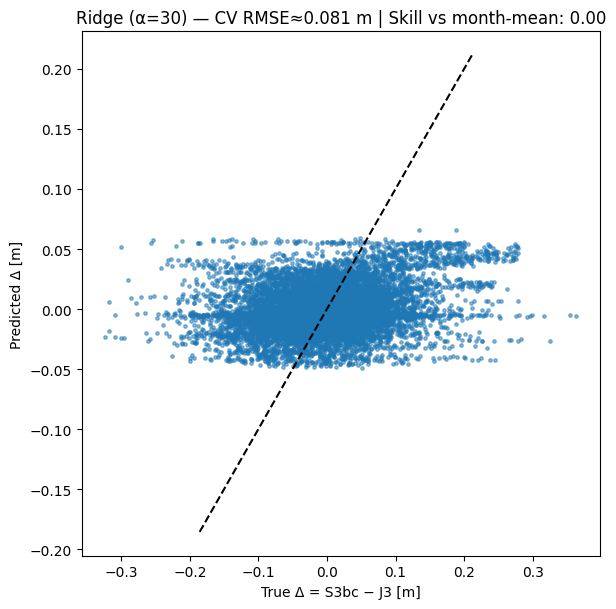

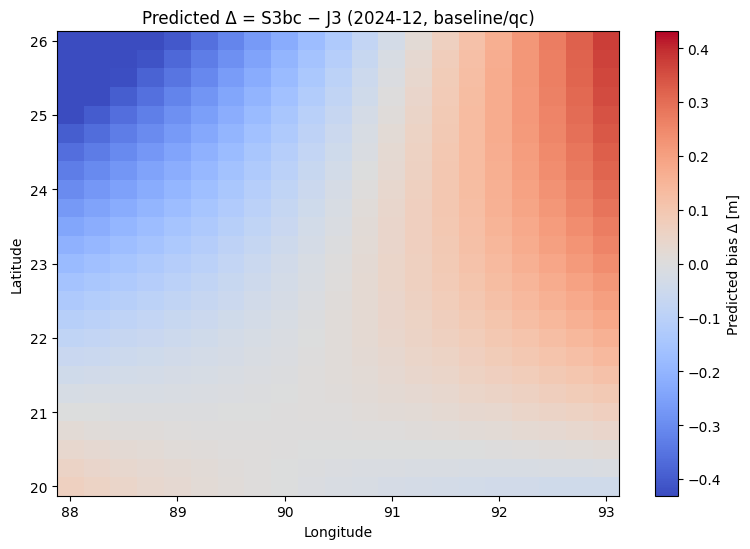

In [12]:
#  Minimal figures (saved + shown)
# 1) y_true vs y_pred
y_hat = final.predict(Xz)
lims = np.nanpercentile(np.r_[y, y_hat], [1,99]); pad = 0.05*(lims[1]-lims[0]); lo, hi = lims[0]-pad, lims[1]+ pad

plt.figure(figsize=(6.2,6.2))
plt.scatter(y, y_hat, s=6, alpha=0.5)
plt.plot([lo,hi],[lo,hi], color="black", ls="--")
plt.xlabel("True Δ = S3bc − J3 [m]"); plt.ylabel("Predicted Δ [m]")
plt.title(f"Ridge (α={best_alpha:g}) — CV RMSE≈{rmse_cv:.3f} m | Skill vs month-mean: {skill_vs_monthmean:.2f}")
plt.tight_layout()
plt.savefig(f"{FIG}/{stem}_scatter.png", dpi=200); plt.show(); plt.close()

# 2) Bias map for target month
lon_u = np.unique(df_map["lon"]); lat_u = np.unique(df_map["lat"])
Z = df_map.pivot(index="lat", columns="lon", values="delta_pred").reindex(index=lat_u, columns=lon_u).to_numpy()
# edges
dlon = np.median(np.diff(lon_u)); dlat = np.median(np.diff(lat_u))
lon_e = np.concatenate([[lon_u[0]-dlon/2], lon_u + dlon/2])
lat_e = np.concatenate([[lat_u[0]-dlat/2], lat_u + dlat/2])

from matplotlib.colors import TwoSlopeNorm
amp = np.nanpercentile(np.abs(Z[np.isfinite(Z)]), 98) if np.isfinite(Z).any() else 0.05
norm = TwoSlopeNorm(vmin=-amp, vcenter=0.0, vmax=amp)

plt.figure(figsize=(7.8,5.6))
pc = plt.pcolormesh(lon_e, lat_e, Z, shading="auto", cmap="coolwarm", norm=norm)
cb = plt.colorbar(pc); cb.set_label("Predicted bias Δ [m]")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title(f"Predicted Δ = S3bc − J3 ({TARG}, {TAG}/{PAIR_KIND})")
plt.tight_layout()
plt.savefig(f"{FIG}/{stem}_map.png", dpi=220); plt.show(); plt.close()

In [13]:
# Save JSON model + metrics
model_json = {
    "generated_utc": datetime.datetime.utcnow().isoformat()+"Z",
    "inputs": {"pairs": os.path.basename(PAIR_FILE)},
    "target": "delta = S3_bc - J3",
    "feature_names": feat_names,
    "scaler": {"mean": mu.tolist(), "std": sd.tolist()},
    "ridge": {"alpha": best_alpha, "coef": coef, "intercept": intercept},
    "projection": {"lon0": lon0, "lat0": lat0},
    "bias_correction": "daily_median_by_date (robust)",
    "grid": {"bbox": BBOX, "res_deg": GRID_RES, "target_month": TARG}
}
with open(f"{OUT}/{stem}_model.json","w") as f: json.dump(model_json, f, indent=2)

pd.DataFrame([{
    "cv_rmse_m": rmse_cv,
    "baseline_rmse_monthmean_m": baseline_rmse,
    "skill_vs_monthmean": skill_vs_monthmean,
    "best_alpha": best_alpha,
    "N_pairs": int(len(df)),
    "months": int(uniq_months.size)
}]).to_csv(f"{OUT}/{stem}_metrics.csv", index=False)

print("Saved:",
      f"{OUT}/{stem}.parquet",
      f"{FIG}/{stem}_scatter.png",
      f"{FIG}/{stem}_map.png",
      f"{OUT}/{stem}_model.json",
      f"{OUT}/{stem}_metrics.csv",
      sep="\n  - ")

Saved:
  - /content/drive/MyDrive/ML/ridge_bias_delta_2024-12_baseline_qc_res0.25.parquet
  - /content/drive/MyDrive/ML/Figures/ridge_bias_delta_2024-12_baseline_qc_res0.25_scatter.png
  - /content/drive/MyDrive/ML/Figures/ridge_bias_delta_2024-12_baseline_qc_res0.25_map.png
  - /content/drive/MyDrive/ML/ridge_bias_delta_2024-12_baseline_qc_res0.25_model.json
  - /content/drive/MyDrive/ML/ridge_bias_delta_2024-12_baseline_qc_res0.25_metrics.csv


In [14]:
import os, json, datetime, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KDTree
from matplotlib.colors import TwoSlopeNorm, LogNorm

In [15]:
# Paths & knobs
BASE      = "/content/drive/MyDrive"
COLL      = f"{BASE}/CollocationV3"
OUT       = f"{BASE}/ML"
FIG       = f"{OUT}/Figures"
os.makedirs(OUT, exist_ok=True); os.makedirs(FIG, exist_ok=True)

# Which pairs to use (consistent with your pipeline)
TAG       = "baseline"     # or "relaxed"
PAIR_KIND = "qc"           # "qc" or "min"
PAIR_FILE = f"{COLL}/s3_j3_pairs_{TAG}_{PAIR_KIND}.parquet"

# Domain & grid
BBOX      = (88.0, 93.0, 20.0, 26.0)   # lon_min, lon_max, lat_min, lat_max
GRID_RES  = 0.05                        # hi-res look (0.05° ≈ 5–6 km)
# Local expert settings (GPSat-style)
TILE_DEG  = 1.0                         # tile size in degrees
OVERLAP   = 0.5                         # tile overlap (deg)
INF_RAD_KM= 120.0                       # inference radius (km) for both train selection + mask
MIN_NN    = 10                          # min neighbors to predict a cell
T_WIN_DAYS= 1.0                         # include +/- this many days around target day
MAX_TRAIN = 20000                       # safety cap per expert (uniform subsample if exceeded)

# GP kernel (anisotropic RBF on [x_km, y_km, t_days] + white noise)
kernel = (
    ConstantKernel(1.0, (1e-2, 10.0)) *
    RBF(length_scale=[60.0, 60.0, 1.5], length_scale_bounds=[(20.0, 200.0), (20.0, 200.0), (0.3, 6.0)]) +
    WhiteKernel(noise_level=0.01**2, noise_level_bounds=(1e-6, 0.05**2))
)

In [16]:
# Load pairs & prep
assert os.path.exists(PAIR_FILE), f"Missing: {PAIR_FILE}"
df = pd.read_parquet(PAIR_FILE).copy()

# expect CollocationV3 columns
need = {"time_s3","lon","lat","sla_s3","sla_j3"}
missing = need - set(df.columns)
assert not missing, f"Pairs missing {missing}"

df["time_s3"] = pd.to_datetime(df["time_s3"], errors="coerce")
df = df.dropna(subset=["time_s3","lon","lat","sla_s3","sla_j3"]).reset_index(drop=True)

# Robust daily-median S3→J3 bias → S3bc (as in your pipeline)
med = (df.assign(date=df["time_s3"].dt.floor("D"))
         .groupby("date")
         .apply(lambda g: np.nanmedian((g["sla_s3"] - g["sla_j3"]).to_numpy(dtype="float64")))
         .rename("daily_median_delta")
         .reset_index())
df = df.merge(med, left_on=df["time_s3"].dt.floor("D"), right_on="date", how="left")
df["sla_bc"] = df["sla_s3"] - df["daily_median_delta"].astype("float64")

# Pick a target day with max coverage (flashiest)
counts = df["time_s3"].dt.floor("D").value_counts().sort_values(ascending=False)
TARGET_DAY = pd.to_datetime(counts.index[0])
print("Target day:", TARGET_DAY.date())

# Filter to +/- T_WIN days around target for spatio-temporal training
t0 = TARGET_DAY
dts = (df["time_s3"] - t0).dt.total_seconds()/86400.0
m_win = np.abs(dts) <= T_WIN_DAYS
work = df.loc[m_win, ["time_s3","lon","lat","sla_bc"]].copy()
work["t_days"] = dts[m_win].to_numpy()

# Domain box (light trim)
lon_min, lon_max, lat_min, lat_max = BBOX
work = work[(work["lon"].between(lon_min, lon_max)) & (work["lat"].between(lat_min, lat_max))].copy()
assert len(work) > 100, f"Too few points after windowing: {len(work)}"

# Local projection to km around domain center
lon0 = float(np.nanmean(work["lon"])); lat0 = float(np.nanmean(work["lat"]))
def to_xy_km(lon, lat, lon0=lon0, lat0=lat0):
    lon = np.asarray(lon, dtype="float64"); lat = np.asarray(lat, dtype="float64")
    x = (lon - lon0) * 111.320 * np.cos(np.deg2rad(lat0))
    y = (lat - lat0) * 110.574
    return np.c_[x, y]

XY = to_xy_km(work["lon"].to_numpy(), work["lat"].to_numpy())
T  = work["t_days"].to_numpy().reshape(-1,1)
X_train = np.hstack([XY, T])            # [x_km, y_km, t_days]
y_train = work["sla_bc"].to_numpy(dtype="float64")

# Grid to predict
LON = np.arange(lon_min, lon_max + 1e-12, GRID_RES)
LAT = np.arange(lat_min, lat_max + 1e-12, GRID_RES)
LONm, LATm = np.meshgrid(LON, LAT)
XYg  = to_xy_km(LONm.ravel(), LATm.ravel())
Tg   = np.zeros((XYg.shape[0], 1), dtype="float64")  # predict at target day (t=0)
X_grid = np.hstack([XYg, Tg])

# Helper: make tiles with overlap
def tile_edges(minv, maxv, size, overlap):
    starts = []
    s = minv
    while s < maxv:
        e = min(s + size, maxv)
        starts.append((s, e))
        if e == maxv: break
        s = e - overlap
    return starts

lon_tiles = tile_edges(lon_min, lon_max, TILE_DEG, OVERLAP)
lat_tiles = tile_edges(lat_min, lat_max, TILE_DEG, OVERLAP)

# Global accumulators (inverse-variance blending across overlapping experts)
nlat, nlon = LAT.size, LON.size
sum_w  = np.zeros((nlat, nlon), dtype="float64")
sum_wm = np.zeros((nlat, nlon), dtype="float64")
sum_nn = np.zeros((nlat, nlon), dtype="int32")   # neighbor support

# Precompute KDTree for neighbor masks (xy only)
tree = KDTree(XY)

# Loop tiles → fit tiny GP → predict
for (lo0, lo1) in lon_tiles:
    for (la0, la1) in lat_tiles:
        # grid indices inside tile
        gi = (LONm >= lo0) & (LONm <= lo1) & (LATm >= la0) & (LATm <= la1)
        if not gi.any(): continue
        gi_idx = np.where(gi.ravel())[0]
        XYg_tile = XYg[gi_idx]

        # training selection: within inference radius of the tile center (fast bbox prefilter)
        lon_c = 0.5*(lo0+lo1); lat_c = 0.5*(la0+la1)
        XY_tile_center = to_xy_km(np.array([lon_c]), np.array([lat_c]))  # (1,2)
        # use KDTree radius to find nearby training points
        idxs = tree.query_radius(XY_tile_center, r=INF_RAD_KM, return_distance=False)[0]
        if idxs.size < MIN_NN:
            continue

        X_tr = X_train[idxs]
        y_tr = y_train[idxs]

        # uniform decimation if too many points for this expert
        if X_tr.shape[0] > MAX_TRAIN:
            stride = int(np.ceil(X_tr.shape[0] / MAX_TRAIN))
            X_tr = X_tr[::stride]
            y_tr = y_tr[::stride]

        # Predict only at grid cells with enough neighbors in radius
        # (compute neighbor counts around each grid cell center)
        nn_counts = tree.query_radius(XYg_tile, r=INF_RAD_KM, count_only=True)
        keep = nn_counts >= MIN_NN
        if not np.any(keep):
            continue
        gi_keep = gi_idx[keep]
        Xg_tile = np.hstack([XYg[gi_keep], np.zeros((gi_keep.size,1))])  # t=0

        # Fit small GP
        gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=1, random_state=42)
        try:
            gpr.fit(X_tr, y_tr)
        except Exception as e:
            # skip pathological tiles
            print("Skip tile fit error:", e)
            continue

        mu, std = gpr.predict(Xg_tile, return_std=True)
        var = np.maximum(std.astype("float64")**2, 1e-8)
        w = 1.0/var

        # accumulate (inverse-variance blend)
        jj = np.unravel_index(gi_keep, (nlat, nlon))
        sum_w [jj] += w
        sum_wm[jj] += w * mu
        sum_nn[jj] += nn_counts[keep].astype("int32")

# Final stitched fields
mean_grid = np.full((nlat, nlon), np.nan, dtype="float32")
std_grid  = np.full((nlat, nlon), np.nan, dtype="float32")
m = sum_w > 0
mean_grid[m] = (sum_wm[m] / sum_w[m]).astype("float32")
std_grid[m]  = np.sqrt(1.0/np.maximum(sum_w[m], 1e-12)).astype("float32")

# Save grid as tidy Parquet
out_stem = f"gpsat_style_map_{TARGET_DAY.date()}_{TAG}_{PAIR_KIND}_res{GRID_RES}_rad{INF_RAD_KM}"
df_map = pd.DataFrame({
    "lon": LONm.ravel(), "lat": LATm.ravel(),
    "mean": mean_grid.ravel(), "std": std_grid.ravel(),
    "n_neighbors": sum_nn.ravel()
})
df_map.to_parquet(f"{OUT}/{out_stem}.parquet", index=False)
print("Saved:", f"{OUT}/{out_stem}.parquet")


/tmp/ipython-input-1080915496.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.nanmedian((g["sla_s3"] - g["sla_j3"]).to_numpy(dtype="float64")))


Target day: 2024-10-25


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 20.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified lower bound 20.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: Conve

Saved: /content/drive/MyDrive/ML/gpsat_style_map_2024-10-25_baseline_qc_res0.05_rad120.0.parquet


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 20.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified lower bound 20.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: Conve

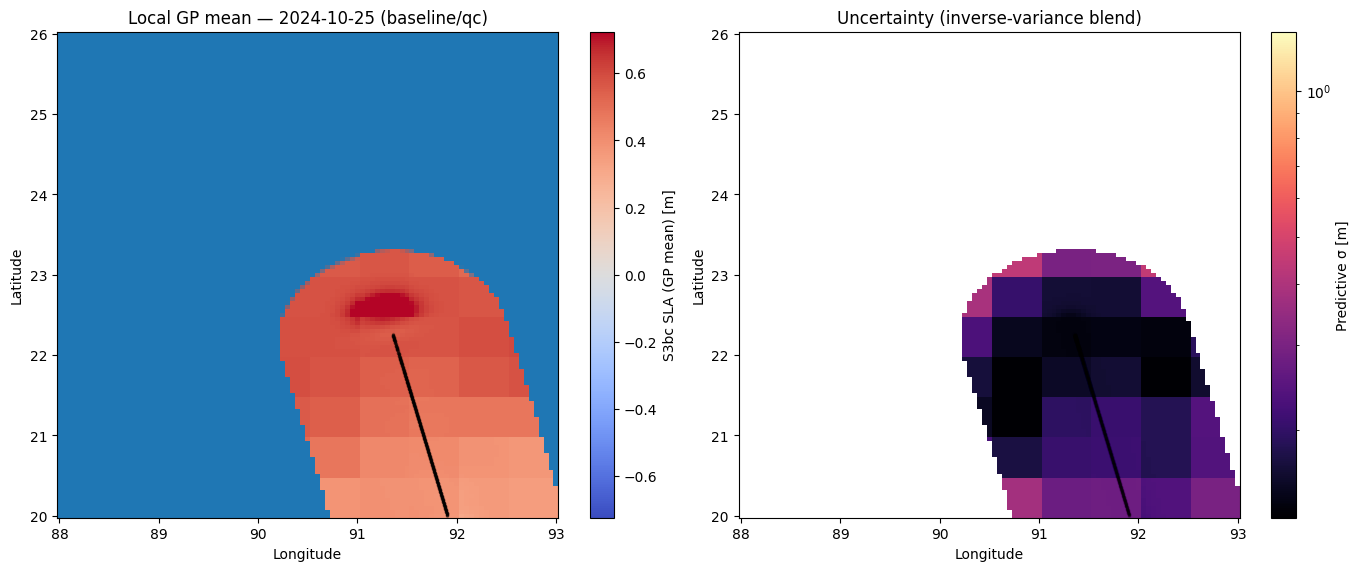

Saved figure: /content/drive/MyDrive/ML/Figures/gpsat_style_map_2024-10-25_baseline_qc_res0.05_rad120.0.png
Saved: /content/drive/MyDrive/ML/gpsat_style_map_2024-10-25_baseline_qc_res0.05_rad120.0_runlog.json


In [17]:
# figure
lon_u = np.unique(df_map["lon"]); lat_u = np.unique(df_map["lat"])
Zm = df_map.pivot(index="lat", columns="lon", values="mean").reindex(index=lat_u, columns=lon_u).to_numpy()
Zu = df_map.pivot(index="lat", columns="lon", values="std").reindex(index=lat_u, columns=lon_u).to_numpy()
Zc = df_map.pivot(index="lat", columns="lon", values="n_neighbors").reindex(index=lat_u, columns=lon_u).to_numpy()

# edges
dlon = np.median(np.diff(lon_u)); dlat = np.median(np.diff(lat_u))
lon_e = np.concatenate([[lon_u[0]-dlon/2], lon_u + dlon/2])
lat_e = np.concatenate([[lat_u[0]-dlat/2], lat_u + dlat/2])

# zero-centered color scaling
finite_vals = Zm[np.isfinite(Zm)]
amp = np.nanpercentile(np.abs(finite_vals), 98) if finite_vals.size else 0.2
norm0 = TwoSlopeNorm(vmin=-amp, vcenter=0.0, vmax=amp)

# dynamic alpha mask by neighbor support (GPSat-style coverage cue)
alpha_mask = np.clip((Zc - MIN_NN)/(MIN_NN*2), 0, 1)   # fade if close to threshold

fig, axs = plt.subplots(1,2, figsize=(13.5,5.6), constrained_layout=True)

# Mean
pc0 = axs[0].pcolormesh(lon_e, lat_e, Zm, shading="auto", cmap="coolwarm", norm=norm0)
# apply alpha via overlay (matplotlib trick)
im_alpha = axs[0].pcolormesh(lon_e, lat_e, np.ones_like(Zm), shading="auto",
                             cmap="gray", vmin=0, vmax=1, alpha=1-alpha_mask)
im_alpha.set_array(None)  # keep layer purely for alpha
cb0 = fig.colorbar(pc0, ax=axs[0]); cb0.set_label("S3bc SLA (GP mean) [m]")
axs[0].set_title(f"Local GP mean — {TARGET_DAY.date()} ({TAG}/{PAIR_KIND})")
axs[0].set_xlabel("Longitude"); axs[0].set_ylabel("Latitude")

# Uncertainty (log scale)
Zu_clip = np.where(np.isfinite(Zu), np.maximum(Zu, 1e-4), np.nan)
umin = np.nanpercentile(Zu_clip, 5) if np.isfinite(Zu_clip).any() else 1e-4
umax = np.nanpercentile(Zu_clip,95) if np.isfinite(Zu_clip).any() else 0.1
pc1 = axs[1].pcolormesh(lon_e, lat_e, Zu_clip, shading="auto", cmap="magma",
                        norm=LogNorm(vmin=max(1e-4, umin), vmax=max(umin*10, umax)))
cb1 = fig.colorbar(pc1, ax=axs[1]); cb1.set_label("Predictive σ [m]")
axs[1].set_title("Uncertainty (inverse-variance blend)")
axs[1].set_xlabel("Longitude"); axs[1].set_ylabel("Latitude")

# Overlay the SRAL shots used that day (grey)
pts = df.loc[df["time_s3"].dt.floor("D") == TARGET_DAY, ["lon","lat"]]
axs[0].scatter(pts["lon"], pts["lat"], s=6, c="k", alpha=0.25, lw=0)
axs[1].scatter(pts["lon"], pts["lat"], s=6, c="k", alpha=0.15, lw=0)

# Save + show
png = f"{FIG}/{out_stem}.png"
fig.savefig(png, dpi=220, bbox_inches="tight")
plt.show(); plt.close(fig)
print("Saved figure:", png)

# Small run log
runlog = {
  "generated_utc": datetime.datetime.utcnow().isoformat()+"Z",
  "pairs": os.path.basename(PAIR_FILE),
  "target_day": str(TARGET_DAY.date()),
  "bbox": BBOX,
  "grid_res_deg": GRID_RES,
  "tile_deg": TILE_DEG, "overlap_deg": OVERLAP,
  "inference_radius_km": INF_RAD_KM, "min_neighbors": MIN_NN,
  "time_window_days": T_WIN_DAYS,
  "kernel": "Const * RBF([60km,60km,1.5d]) + White",
}
with open(f"{OUT}/{out_stem}_runlog.json","w") as f:
    json.dump(runlog, f, indent=2)
print("Saved:", f"{OUT}/{out_stem}_runlog.json")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 29.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading:

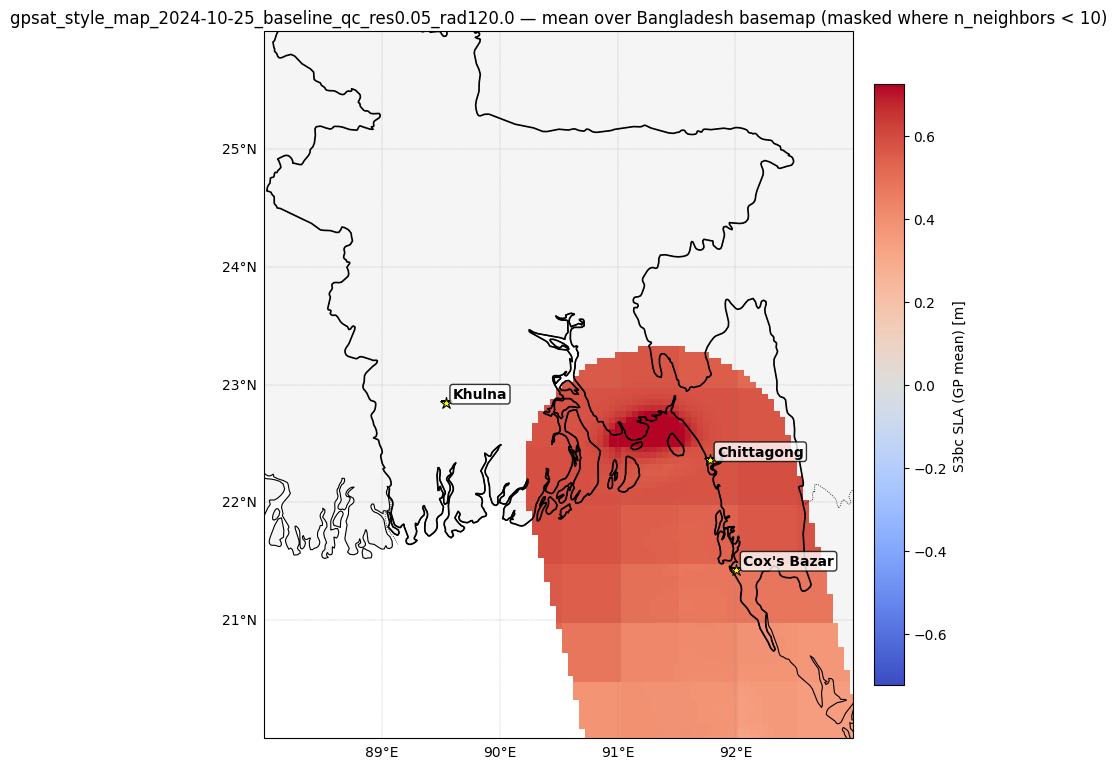

Saved: /content/drive/MyDrive/ML/Figures/gpsat_style_map_2024-10-25_baseline_qc_res0.05_rad120.0_bangladesh_basemap.png


In [19]:
# Bangladesh basemap overlay for GPSat-style field (mean)

from google.colab import drive; drive.mount('/content/drive', force_remount=False)
%pip -q install cartopy shapely pyproj

import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# Paths
BASE = globals().get("BASE", "/content/drive/MyDrive")
OUT  = globals().get("OUT",  f"{BASE}/ML")
FIG  = globals().get("FIG",  f"{OUT}/Figures")
os.makedirs(FIG, exist_ok=True)

# Load the stitched GP map (mean/std/n_neighbors)
if "df_map" in globals():
    _map = df_map.copy()
    stem = globals().get("out_stem", "gpsat_style_map_custom")
else:
    if "out_stem" in globals() and os.path.exists(f"{OUT}/{out_stem}.parquet"):
        parquet = f"{OUT}/{out_stem}.parquet"
    else:
        cands = sorted(glob.glob(f"{OUT}/gpsat_style_map_*.parquet"))
        assert len(cands) > 0, "No gpsat_style_map_*.parquet found under ML/."
        parquet = cands[-1]
        stem = os.path.splitext(os.path.basename(parquet))[0]
    _map = pd.read_parquet(parquet)

# Prep gridded arrays for pcolormesh
lon_u = np.unique(_map["lon"].to_numpy())
lat_u = np.unique(_map["lat"].to_numpy())
Zm = _map.pivot(index="lat", columns="lon", values="mean").reindex(index=lat_u, columns=lon_u).to_numpy()
Zc = _map.pivot(index="lat", columns="lon", values="n_neighbors").reindex(index=lat_u, columns=lon_u).to_numpy()

# zero-centered color scale around 0
finite_vals = Zm[np.isfinite(Zm)]
amp = np.nanpercentile(np.abs(finite_vals), 98) if finite_vals.size else 0.2
norm0 = TwoSlopeNorm(vmin=-amp, vcenter=0.0, vmax=amp)

# pcolormesh edges
dlon = np.median(np.diff(lon_u)) if len(lon_u)>1 else 0.05
dlat = np.median(np.diff(lat_u)) if len(lat_u)>1 else 0.05
lon_e = np.concatenate([[lon_u[0] - dlon/2], lon_u + dlon/2])
lat_e = np.concatenate([[lat_u[0] - dlat/2], lat_u + dlat/2])

# hard mask cells with weak neighbor support
MIN_NN = 10
Zm_plot = np.ma.masked_where((Zc < MIN_NN) | ~np.isfinite(Zm), Zm)

# ---- Real-world points to annotate (edit as needed) ----
POINTS = [
    ("Chittagong", 22.3569, 91.7832),
    ("Khulna",     22.8456, 89.5403),
    ("Cox's Bazar",21.4272, 92.0058),
]
# Map extent (Bangladesh region)
BBOX = (88.0, 93.0, 20.0, 26.0)  # lon_min, lon_max, lat_min, lat_max

# Build the basemap figure
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10.5, 7.8))
ax = plt.axes(projection=proj)
ax.set_extent(BBOX, crs=proj)

# Land/sea/coast/borders
ax.add_feature(cfeature.LAND.with_scale("10m"), facecolor="0.96", zorder=0)
ax.add_feature(cfeature.OCEAN.with_scale("10m"), facecolor="white", zorder=0)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.8, zorder=2)
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6, linestyle=":", zorder=2)

# Highlight Bangladesh polygon outline
shpfile = shpreader.natural_earth(resolution="10m", category="cultural", name="admin_0_countries")
for rec in shpreader.Reader(shpfile).records():
    if rec.attributes.get("ADMIN") == "Bangladesh":
        ax.add_geometries([rec.geometry], crs=proj, facecolor="none", edgecolor="k", linewidth=1.2, zorder=3)
        break

# Gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.6, linestyle="--")
gl.top_labels = False; gl.right_labels = False

# Field overlay
pc = ax.pcolormesh(lon_e, lat_e, Zm_plot, transform=proj, shading="auto", cmap="coolwarm", norm=norm0, zorder=1)
cb = plt.colorbar(pc, ax=ax, shrink=0.85, pad=0.02); cb.set_label("S3bc SLA (GP mean) [m]")

# Annotate sites
for name, lat, lon in POINTS:
    ax.plot(lon, lat, marker="*", ms=9, mfc="yellow", mec="k", mew=0.8, transform=proj, zorder=5)
    ax.text(lon+0.06, lat+0.04, name, transform=proj, fontsize=10, weight="bold",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.8), zorder=6)

plt.title(f"{stem} — mean over Bangladesh basemap (masked where n_neighbors < {MIN_NN})")
plt.tight_layout()

out_png = f"{FIG}/{stem}_bangladesh_basemap.png"
plt.savefig(out_png, dpi=220, bbox_inches="tight")
plt.show(); plt.close()
print("Saved:", out_png)
